In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = int(np.sqrt(input_dim))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
class Autoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        # Set hyperparameters
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        # Build the graph
        self.build()

        # Initialize paramters
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        tf.reset_default_graph()        
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z = fc(f3, self.n_z, scope='enc_fc4', activation_fn=tf.nn.relu)

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Optimizer
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.recon_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss
        }
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z    

In [4]:
def trainer(model_class, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, log_step=5):
    # Create a model    
    model = model_class(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    # Training loop    
    for epoch in range(num_epoch):
        start_time = time.time()
        
        # Run an epoch
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and backward pass 
            # Report computed loss
            losses = model.run_single_step(batch[0])
        end_time = time.time()
        
        # Log the loss
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [5]:
# Train a model
model = trainer(Autoencoder)

[Epoch 0] recon_loss: 155.271  (3.412 sec/epoch)
[Epoch 5] recon_loss: 96.935  (3.280 sec/epoch)
[Epoch 10] recon_loss: 100.304  (3.225 sec/epoch)
[Epoch 15] recon_loss: 91.481  (3.149 sec/epoch)
[Epoch 20] recon_loss: 84.946  (3.133 sec/epoch)
[Epoch 25] recon_loss: 87.114  (3.349 sec/epoch)
[Epoch 30] recon_loss: 83.550  (3.130 sec/epoch)
[Epoch 35] recon_loss: 78.729  (3.143 sec/epoch)
[Epoch 40] recon_loss: 83.043  (3.141 sec/epoch)
[Epoch 45] recon_loss: 80.203  (3.176 sec/epoch)
[Epoch 50] recon_loss: 79.668  (3.281 sec/epoch)
[Epoch 55] recon_loss: 79.107  (3.160 sec/epoch)
[Epoch 60] recon_loss: 84.839  (3.251 sec/epoch)
[Epoch 65] recon_loss: 73.612  (3.162 sec/epoch)
[Epoch 70] recon_loss: 76.818  (3.149 sec/epoch)
[Epoch 75] recon_loss: 75.412  (3.139 sec/epoch)
[Epoch 80] recon_loss: 75.053  (3.191 sec/epoch)
[Epoch 85] recon_loss: 80.290  (3.125 sec/epoch)
[Epoch 90] recon_loss: 72.095  (3.150 sec/epoch)
[Epoch 95] recon_loss: 69.671  (3.202 sec/epoch)
Done!


In [6]:
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
    # Test the trained model: reconstruction
    batch = mnist.test.next_batch(batch_size)
    x_reconstructed = model.reconstructor(batch[0])

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[0][i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

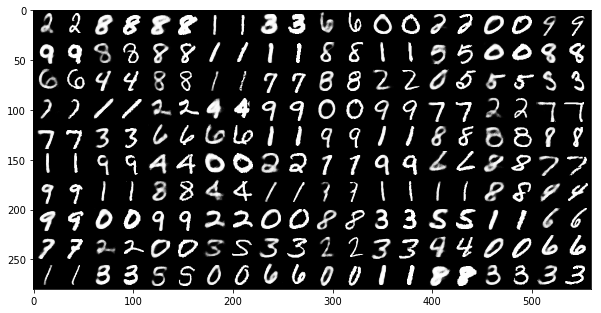

In [7]:
test_reconstruction(model, mnist)

In [8]:
# Train a model with 2d latent space
model_2d = trainer(Autoencoder, n_z=2)

/home/walter/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] recon_loss: 188.842  (3.199 sec/epoch)
[Epoch 5] recon_loss: 184.486  (3.232 sec/epoch)
[Epoch 10] recon_loss: 168.626  (3.220 sec/epoch)
[Epoch 15] recon_loss: 151.403  (3.198 sec/epoch)
[Epoch 20] recon_loss: 148.732  (3.162 sec/epoch)
[Epoch 25] recon_loss: 136.923  (3.130 sec/epoch)
[Epoch 30] recon_loss: 137.905  (3.158 sec/epoch)
[Epoch 35] recon_loss: 143.643  (3.260 sec/epoch)
[Epoch 40] recon_loss: 143.484  (3.221 sec/epoch)
[Epoch 45] recon_loss: 138.996  (3.205 sec/epoch)
[Epoch 50] recon_loss: 135.020  (3.145 sec/epoch)
[Epoch 55] recon_loss: 137.817  (3.197 sec/epoch)
[Epoch 60] recon_loss: 132.836  (3.215 sec/epoch)
[Epoch 65] recon_loss: 132.054  (3.203 sec/epoch)
[Epoch 70] recon_loss: 133.366  (3.267 sec/epoch)
[Epoch 75] recon_loss: 135.322  (3.159 sec/epoch)
[Epoch 80] recon_loss: 148.316  (3.174 sec/epoch)
[Epoch 85] recon_loss: 128.316  (3.219 sec/epoch)
[Epoch 90] recon_loss: 129.504  (3.186 sec/epoch)
[Epoch 95] recon_loss: 143.637  (3.181 sec/epoch)
Do

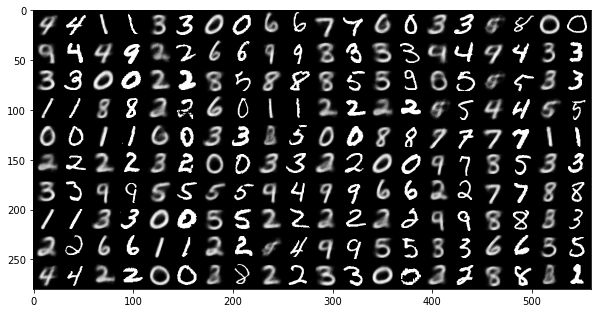

In [9]:
test_reconstruction(model_2d, mnist)

In [10]:
def test_transformation(model_2d, mnist, batch_size=3000):
    # Test the trained model: transformation
    assert model_2d.n_z == 2
    batch = mnist.test.next_batch(batch_size)
    z = model_2d.transformer(batch[0])
    plt.figure(figsize=(10, 8)) 
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1), s=20)
    plt.colorbar()
    plt.grid()

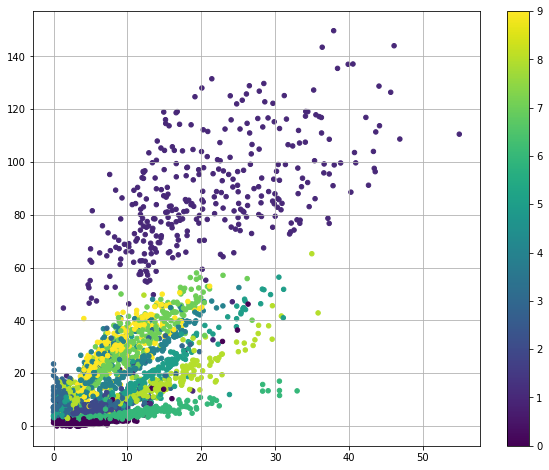

In [11]:
test_transformation(model_2d, mnist)

In [12]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        # Set hyperparameters
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        # Build the graph
        self.build()

        # Initialize paramters
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        tf.reset_default_graph()
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [13]:
# Train a vae model
model_vae = trainer(VariantionalAutoencoder)

/home/walter/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] recon_loss: 184.303  total_loss: 188.932  latent_loss: 4.629  (4.195 sec/epoch)
[Epoch 5] recon_loss: 120.460  total_loss: 136.042  latent_loss: 15.582  (4.028 sec/epoch)
[Epoch 10] recon_loss: 103.622  total_loss: 122.162  latent_loss: 18.540  (4.029 sec/epoch)
[Epoch 15] recon_loss: 105.282  total_loss: 124.568  latent_loss: 19.286  (4.088 sec/epoch)
[Epoch 20] recon_loss: 93.845  total_loss: 113.619  latent_loss: 19.774  (4.044 sec/epoch)
[Epoch 25] recon_loss: 92.022  total_loss: 111.345  latent_loss: 19.323  (4.088 sec/epoch)
[Epoch 30] recon_loss: 95.671  total_loss: 115.675  latent_loss: 20.004  (3.978 sec/epoch)
[Epoch 35] recon_loss: 90.963  total_loss: 110.965  latent_loss: 20.002  (4.106 sec/epoch)
[Epoch 40] recon_loss: 95.569  total_loss: 116.024  latent_loss: 20.455  (4.116 sec/epoch)
[Epoch 45] recon_loss: 91.803  total_loss: 113.235  latent_loss: 21.432  (4.009 sec/epoch)
[Epoch 50] recon_loss: 84.315  total_loss: 104.877  latent_loss: 20.563  (4.056 sec/epoch

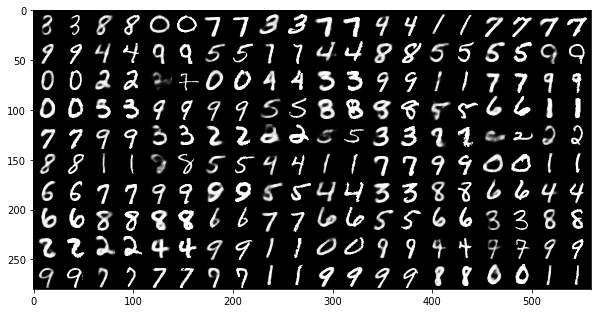

In [14]:
test_reconstruction(model_vae, mnist)

In [15]:
def test_generation(model, z=None, h=28, w=28, batch_size=100):
    # Test the trained model: generation
    # Sample noise vectors from N(0, 1)
    if z is None:
        z = np.random.normal(size=[batch_size, model.n_z])
    x_generated = model.generator(z)    

    n = np.sqrt(batch_size).astype(np.int32)
    I_generated = np.empty((h*n, w*n))
    for i in range(n):
        for j in range(n):
            I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)
            
    plt.figure(figsize=(8, 8))
    plt.imshow(I_generated, cmap='gray')

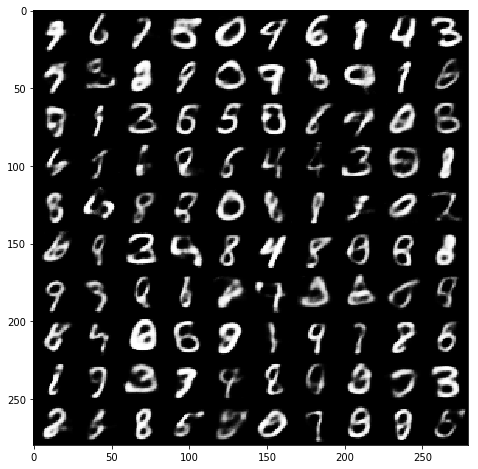

In [16]:
test_generation(model_vae)

In [17]:
# Train a model with 2d latent space
model_vae_2d = trainer(VariantionalAutoencoder, n_z=2)

/home/walter/.local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] recon_loss: 188.125  total_loss: 192.607  latent_loss: 4.481  (3.991 sec/epoch)
[Epoch 5] recon_loss: 165.833  total_loss: 170.368  latent_loss: 4.535  (3.995 sec/epoch)
[Epoch 10] recon_loss: 152.068  total_loss: 157.655  latent_loss: 5.586  (4.092 sec/epoch)
[Epoch 15] recon_loss: 152.884  total_loss: 158.331  latent_loss: 5.447  (4.000 sec/epoch)
[Epoch 20] recon_loss: 144.176  total_loss: 150.032  latent_loss: 5.856  (4.107 sec/epoch)
[Epoch 25] recon_loss: 148.507  total_loss: 154.287  latent_loss: 5.781  (4.041 sec/epoch)
[Epoch 30] recon_loss: 148.343  total_loss: 154.139  latent_loss: 5.796  (4.019 sec/epoch)
[Epoch 35] recon_loss: 141.315  total_loss: 147.392  latent_loss: 6.078  (3.997 sec/epoch)
[Epoch 40] recon_loss: 134.880  total_loss: 141.038  latent_loss: 6.158  (3.960 sec/epoch)
[Epoch 45] recon_loss: 132.386  total_loss: 138.701  latent_loss: 6.315  (4.014 sec/epoch)
[Epoch 50] recon_loss: 138.197  total_loss: 144.526  latent_loss: 6.329  (4.032 sec/epoch)
[

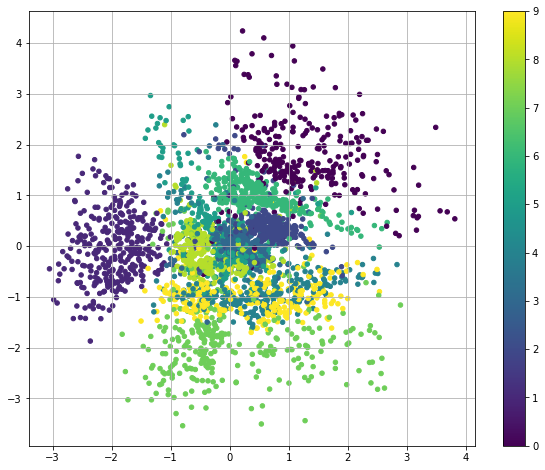

In [18]:
test_transformation(model_vae_2d, mnist)

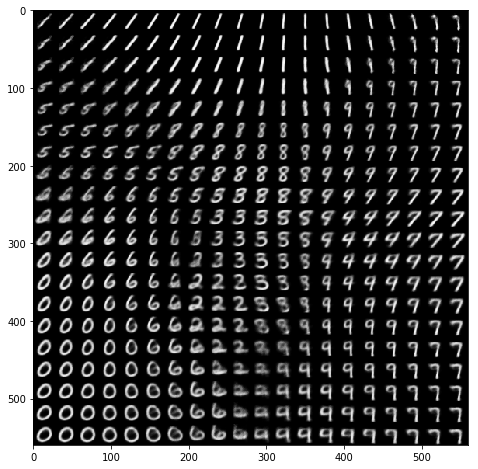

In [19]:
# Test the trained model: uniformly samlpe in the latent space
n = 20
x = np.linspace(-2, 2, n)
y = np.flip(np.linspace(-2, 2, n))
z = []
for i, xi in enumerate(x):
    for j, yi in enumerate(y):
        z.append(np.array([xi, yi]))
z = np.stack(z)

# generate images
test_generation(model_vae_2d, z, batch_size=n**2)